In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
#random seed 고정
import random
import torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
# CIFAR10 데이터 셋 불러오기
import torchvision
import torchvision.transforms as transforms

# 배치사이즈 설정
batch_size = 64

# CIFAR10의 Train 데이터의 평균과 표준편차값을 구하기 위한 과정
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True) 
mean = dataset.data.mean(axis=(0,1,2))
std = dataset.data.std(axis=(0,1,2))
mean = mean / 255 # 평균
std = std / 255 # 표준편차


# data augmentation 정의
# pytorch에서는 torchvision.transforms.ToTensor를 이용하여 [0, 1]까지의 정규화와 torch.FloatTensor형으로 형변환을 함께 진행할 수 있으며,
# torchvision.transforms.Normalize를 통해 평균과 표준편차 값을 이용한 정규화를 수행할 수 있음.
transform_1 = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.RandomHorizontalFlip()
    ])
transform_2 = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# normalize transformation 적용
# train 데이터 읽어오기
trainSet = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True, 
                                        download=True, 
                                        transform=transform_1)

# test 데이터 읽어오기
testSet = torchvision.datasets.CIFAR10(root='./data',
                                      train=False,
                                      download=True,
                                      transform=transform_2)

print("training data = ", trainSet.data[0].shape)
print("testing data = ", testSet.data[0].shape)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
training data =  (32, 32, 3)
testing data =  (32, 32, 3)


In [5]:
# model 정의
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(32,32,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(64,64,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv_block_6 = nn.Sequential(
            nn.Conv2d(128,128,kernel_size=3,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        self.dense = nn.Linear(128*4*4,10)
        
    def forward(self, data) :
        x = self.conv_block_1(data)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = self.conv_block_6(x)
        
        x = x.view(-1, 128*4*4)
        x = self.dense(x)
        output = F.log_softmax(x,dim=1)
        
        return output

In [6]:
# DEVICE 초기화
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"DEVICE:{DEVICE}")

DEVICE:cuda


In [7]:
# model 초기화
model = Net().to(DEVICE)

In [8]:
%pip install torchsummary # model을 요약하기 위해 torchsummary 설치
from torchsummary import summary as summary_# 모델 정보를 확인하기 위해 torchsummary 함수 import

# 모델의 형태를 출력하기 위한 함수 
def summary_model(model,input_shape=(3, 32, 32)):
    model = model.cuda()
    summary_(model, input_shape) # (model, (input shape))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
summary_model(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          18,496
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
           Conv2d-12           [-1, 64, 16, 16]          36,928
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1, 64,

In [ ]:
# 모델 학습하기
import time

# train, test 데이터셋의 로더
# 배치사이즈와 불러오는 데이터를 섞을지 결정할 수 있다
trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testSet, batch_size=1,shuffle=False)

# 파라미터 설정
total_epoch = 250
best_loss = 100 # loss를 기준으로 best_checkpoint를 저장하기 위해 100으로 설정하였음.

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005,weight_decay=1e-6) # Adam을 최적화 함수로 이용함. 파라미터는 documentation을 참조!
loss = torch.nn.CrossEntropyLoss().cuda() # 분류문제이므로 CrossEntropyLoss를 이용함

# 모델 시각화를 위해 정확도를 저장할 리스트 생성
train_accuracys=[]
eval_accuracys=[]

for epoch in range(total_epoch):
    start = time.time()
    print(f'Epoch {epoch}/{total_epoch}')

    # train
    train_loss = 0
    correct = 0
    for x, target in trainloader: # 한번에 배치사이즈만큼 데이터를 불러와 모델을 학습함

        optimizer.zero_grad() # 이전 loss를 누적하지 않기 위해 0으로 설정해주는 과정
        y_pred = model(x.cuda()) # 모델의 출력값
        cost = loss(y_pred, target.cuda()) # loss 함수를 이용하여 오차를 계산함
    
        cost.backward() # gradient 구하기 
        optimizer.step() # 모델 학습
        train_loss += cost.item()
        
        pred = y_pred.data.max(1, keepdim=True)[1] # 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
        correct += pred.cpu().eq(target.data.view_as(pred)).sum() # pred와 target을 비교하여 맞은 개수를 구하는 과정.
                                                                  # view_as함수는 들어가는 인수의 모양으로 맞춰주고, .eq()를 통해 pred와 target의 값이 동일한지 판단하여 True 개수 구하기
        
    train_loss /= len(trainloader)
    train_accuracy = correct / len(trainloader.dataset)
    train_accuracys.append(train_accuracy) # 그래프로 표현하기 위해 리스트에 담음

    
    # Evaluate
    eval_loss = 0
    correct = 0
    with torch.no_grad(): # 학습하지 않기 위해
        model.eval() # 평가 모드로 변경
        for x, target in testloader:
            y_pred = model(x.cuda()) # 모델의 출력값
            cost = loss(y_pred,target.cuda()) # loss 함수를 이용하여 test 데이터의 오차를 계산함
            eval_loss += cost
            
            pred = y_pred.data.max(1, keepdim=True)[1] # 각 클래스의 확률 값 중 가장 큰 값을 가지는 클래스의 인덱스를 pred 변수로 받음
            correct += pred.cpu().eq(target.data.view_as(pred)).cpu().sum() # pred와 target을 비교하여 맞은 개수를 구하는 과정
            
        eval_loss /= len(testloader)
        eval_accuracy = correct / len(testloader.dataset)
        eval_accuracys.append(eval_accuracy) # 그래프로 표현하기 위해 리스트에 담음
        
        # test 데이터의 loss를 기준으로 이전 loss 보다 작을 경우 체크포인트 저장
        if eval_loss < best_loss:
            torch.save({
                'epoch': epoch,
                'model': model,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': cost.item,
                }, './bestCheckPiont.pth')
            
            print(f'Epoch {epoch:05d}: val_loss improved from {best_loss:.5f} to {eval_loss:.5f}, saving model to bestCheckPoint.pth')
            best_loss = eval_loss
        else:
            print(f'Epoch {epoch:05d}: val_loss did not improve')
        model.train()
        
    print(f'{int(time.time() - start)}s - loss: {train_loss:.5f} - acc: {train_accuracy:.5f} - val_loss: {eval_loss:.5f} - val_acc: {eval_accuracy:.5f}')

Epoch 0/250
Epoch 00000: val_loss improved from 100.00000 to 1.07881, saving model to bestCheckPoint.pth
89s - loss: 1.54333 - acc: 0.44742 - val_loss: 1.07881 - val_acc: 0.61360
Epoch 1/250
Epoch 00001: val_loss improved from 1.07881 to 0.86217, saving model to bestCheckPoint.pth
88s - loss: 1.17371 - acc: 0.58178 - val_loss: 0.86217 - val_acc: 0.69080
Epoch 2/250
Epoch 00002: val_loss improved from 0.86217 to 0.77518, saving model to bestCheckPoint.pth
87s - loss: 1.01583 - acc: 0.64026 - val_loss: 0.77518 - val_acc: 0.73000
Epoch 3/250
Epoch 00003: val_loss improved from 0.77518 to 0.69588, saving model to bestCheckPoint.pth
88s - loss: 0.93066 - acc: 0.67382 - val_loss: 0.69588 - val_acc: 0.75650
Epoch 4/250
Epoch 00004: val_loss improved from 0.69588 to 0.67219, saving model to bestCheckPoint.pth
89s - loss: 0.87001 - acc: 0.69468 - val_loss: 0.67219 - val_acc: 0.75930
Epoch 5/250
Epoch 00005: val_loss improved from 0.67219 to 0.61652, saving model to bestCheckPoint.pth
88s - loss

In [ ]:
# 저장되어있는 best 체크포인트 load하기
best_model = torch.load('./bestCheckPiont.pth')['model'] # 전체 모델을 통째로 불러옴, 클래스 선언 필수
best_model.load_state_dict(torch.load('./bestCheckPiont.pth')['model_state_dict']) # state_dict를 불러 온 후, 모델에 저장

<All keys matched successfully>

In [ ]:
# prediction
correct = 0
total = 0

with torch.no_grad(): # 학습하지 않기 위해
    best_model.eval()
    for data, label in testloader:
        outputs = best_model(data.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted == label.cuda()).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


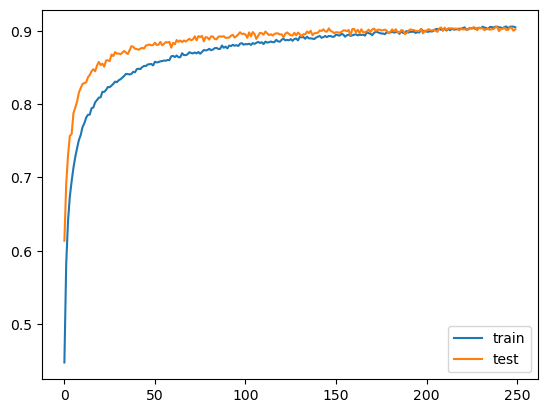

In [ ]:
# train, test 데이터에 대한 epoch당 정확도 시각화하기 

from matplotlib import pyplot as plt

plt.plot(train_accuracys, label='train')
plt.plot(eval_accuracys, label='test')
plt.legend()
plt.show()